In [1]:
"""

FINAL RANDOM FOREST MODEL  

TEST ON HOLD OUT SET

"""

'\n\nFINAL RANDOM FOREST MODEL  \n\nTEST ON HOLD OUT SET\n\n'

In [66]:
import pandas as pd
import numpy as np
import datetime
import pickle

In [67]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score 

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

In [70]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

In [71]:
# the df with features and target

with open('data_model_training.pickle', 'rb') as read_file:
    model_data = pickle.load(read_file)
    
model_data.head()

,company_name,FULL_NAME,period_end_date,submission_number,central_index_key,ein,sic,fiscal_year_end,fiscal_year,form,...,current_ratio,leverage,return_on_equity,return_on_assets,ratio_1,ratio_2,ratio_3,ratio_4,EarningsPerShareBasic,EarningsPerShareDiluted
0,1 800 FLOWERS COM INC,NaN,2014-06-30,0001437749-17-015969,1084869,113117311,5990,630,2017,10-K,...,1.235657,1.460306,NaN,NaN,0.684788,1.179782,3.285030,4.099066,0.24,0.23
1,1 800 FLOWERS COM INC,NaN,2015-06-30,0001437749-18-017027,1084869,113117311,5990,630,2018,10-K,...,1.254743,2.384626,NaN,NaN,0.419353,0.980128,1.733067,1.792763,0.31,0.30
2,1 800 FLOWERS COM INC,NaN,2016-06-30,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,1.378931,2.073248,NaN,NaN,0.482335,1.028864,1.931751,2.104657,0.57,0.55
3,1 800 FLOWERS COM INC,NaN,2017-06-30,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,2.056337,1.957454,0.156042,0.079717,0.510868,0.941736,2.044436,2.043737,0.68,0.65
4,1 800 FLOWERS COM INC,NaN,2018-06-30,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,2.187686,1.812899,0.129535,0.071452,0.551603,0.856603,2.230166,2.031857,0.63,0.61


In [72]:
model_data.shape

(19919, 52)

In [150]:
model_data.isnull().sum().sum()

318057

In [8]:
#model_data.columns

In [73]:
# fill infinity values with NaN

model_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [76]:
## deviation features

def add_deviation_feature(X, feature, category):
    
    # temp groupby object
    category_gb = X.groupby(category)[feature]
    
    # create columns of category means and standard deviations
    category_mean = category_gb.transform(lambda x: x.mean())
    category_std = category_gb.transform(lambda x: x.std())
    
    # compute stds from category mean for each feature value,
    # add to X as new feature
    deviation_feature = (X[feature] - category_mean) / category_std 
    X[feature + '_Dev_' + category] = deviation_feature  

In [77]:
add_deviation_feature(model_data, 'debt_ratio', 'Division')
add_deviation_feature(model_data, 'debt_equity_ratio', 'Division')
add_deviation_feature(model_data, 'current_ratio', 'Division')
add_deviation_feature(model_data, 'leverage', 'Division')
add_deviation_feature(model_data, 'return_on_equity', 'Division')
add_deviation_feature(model_data, 'return_on_assets', 'Division')
add_deviation_feature(model_data, 'ratio_1', 'Division')
add_deviation_feature(model_data, 'ratio_2', 'Division')
add_deviation_feature(model_data, 'ratio_3', 'Division')
add_deviation_feature(model_data, 'ratio_4', 'Division')
add_deviation_feature(model_data, 'EarningsPerShareBasic', 'Division')
add_deviation_feature(model_data, 'EarningsPerShareDiluted', 'Division')

In [83]:
# fill infinity values with NaN

model_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [78]:
model_data.columns

Index(['company_name', 'FULL_NAME', 'period_end_date', 'submission_number',
       'central_index_key', 'ein', 'sic', 'fiscal_year_end', 'fiscal_year',
       'form', 'date_filed', 'Industry', 'div_code', 'Division',
       'bankruptcy_date', 'days', 'target', 'Assets_MM', 'AssetsCurrent_MM',
       'Libilities_MM', 'LibilitiesCurrent_MM', 'NetIncomeLoss_MM',
       'StockholdersEquity_MM', 'OperatingIncomeLoss_MM', 'Revenues_MM',
       'CashAndCashEquivalentsAtCarryingValue_MM', 'CommonStockValue_MM',
       'Goodwill_MM', 'GrossProfit_MM', 'InterestExpense_MM', 'Revenue_any_MM',
       'SalesRevenueGoodsNet_MM', 'SalesRevenueNet_MM',
       'NetCashProvidedByUsedInFinancingActivities_MM',
       'NetCashProvidedByUsedInInvestingActivities_MM',
       'NetCashProvidedByUsedInOperatingActivities_MM',
       'LongTermDebtMaturitiesRepaymentsOfPrincipalInNextTwelveMonths_MM',
       'LongTermDebtNoncurrent_MM', 'LongTermDebt_MM',
       'RepaymentsOfLongTermDebt_MM', 'debt_ratio', 'debt

In [157]:
max(model_data.period_end_date)

Timestamp('2018-12-31 00:00:00')

In [84]:
## split into 3 parts to handle missing

model_ready_1 = model_data[['company_name', 'FULL_NAME', 'period_end_date', 'submission_number',
       'central_index_key', 'ein', 'sic', 'fiscal_year_end', 'fiscal_year',
       'form', 'date_filed', 'Industry', 'div_code', 'Division',
       'bankruptcy_date', 'days', 'target']]

In [85]:
## RF will not accept NaNs

## change all NaN to zero where large values

model_ready_2 = model_data[['Assets_MM', 'AssetsCurrent_MM',
       'Libilities_MM', 'LibilitiesCurrent_MM', 'NetIncomeLoss_MM',
       'StockholdersEquity_MM', 'OperatingIncomeLoss_MM', 'Revenues_MM',
       'CashAndCashEquivalentsAtCarryingValue_MM', 'CommonStockValue_MM',
       'Goodwill_MM', 'GrossProfit_MM', 'InterestExpense_MM', 'Revenue_any_MM',
       'SalesRevenueGoodsNet_MM', 'SalesRevenueNet_MM',
       'NetCashProvidedByUsedInFinancingActivities_MM',
       'NetCashProvidedByUsedInInvestingActivities_MM',
       'NetCashProvidedByUsedInOperatingActivities_MM',
       'LongTermDebtMaturitiesRepaymentsOfPrincipalInNextTwelveMonths_MM',
       'LongTermDebtNoncurrent_MM', 'LongTermDebt_MM',
       'RepaymentsOfLongTermDebt_MM']].fillna(-999999)


In [81]:
min(model_ready_2.OperatingIncomeLoss_MM)

-999999.0

In [82]:
model_ready_2.head()

,Assets_MM,AssetsCurrent_MM,Libilities_MM,LibilitiesCurrent_MM,NetIncomeLoss_MM,StockholdersEquity_MM,OperatingIncomeLoss_MM,Revenues_MM,CashAndCashEquivalentsAtCarryingValue_MM,CommonStockValue_MM,...,Revenue_any_MM,SalesRevenueGoodsNet_MM,SalesRevenueNet_MM,NetCashProvidedByUsedInFinancingActivities_MM,NetCashProvidedByUsedInInvestingActivities_MM,NetCashProvidedByUsedInOperatingActivities_MM,LongTermDebtMaturitiesRepaymentsOfPrincipalInNextTwelveMonths_MM,LongTermDebtNoncurrent_MM,LongTermDebt_MM,RepaymentsOfLongTermDebt_MM
0,267.569,91.818,81.451,74.307,-999999.000,183.228,23.706,-999999.000,5.203,-999999.0,...,756.345,-999999.0,756.345,-6.002,-31.488,42.539,-999999.0,-999999.0,-999999.0,-999999.0
1,497.073,155.095,286.817,123.607,-999999.000,208.449,37.617,-999999.000,27.940,-999999.0,...,1121.506,-999999.0,1121.506,60.607,-163.603,125.733,-999999.0,-999999.0,-999999.0,-999999.0
2,502.941,166.659,260.355,120.861,-999999.000,242.586,43.282,1173.024,27.826,-999999.0,...,1173.024,-999999.0,1173.024,-23.849,-33.938,57.673,-999999.0,-999999.0,-999999.0,-999999.0
3,552.470,257.402,270.231,125.175,44.041,282.239,46.359,1193.625,149.732,-999999.0,...,1193.625,-999999.0,1193.625,-17.406,78.302,61.010,-999999.0,-999999.0,-999999.0,-999999.0
4,570.889,273.021,255.985,124.799,40.791,314.904,41.048,1151.921,147.240,-999999.0,...,1151.921,-999999.0,-999999.000,-19.027,-41.806,58.341,-999999.0,-999999.0,-999999.0,-999999.0


In [86]:
## change to large extreme negative where ratios

model_ready_3 = model_data[['debt_ratio', 'debt_equity_ratio',
       'current_ratio', 'leverage', 'return_on_equity', 'return_on_assets',
       'ratio_1', 'ratio_2', 'ratio_3', 'ratio_4', 'EarningsPerShareBasic',
       'EarningsPerShareDiluted', 'debt_ratio_Dev_Division',
       'debt_equity_ratio_Dev_Division', 'current_ratio_Dev_Division',
       'leverage_Dev_Division', 'return_on_equity_Dev_Division',
       'return_on_assets_Dev_Division', 'ratio_1_Dev_Division',
       'ratio_2_Dev_Division', 'ratio_3_Dev_Division', 'ratio_4_Dev_Division',
       'EarningsPerShareBasic_Dev_Division',
       'EarningsPerShareDiluted_Dev_Division']].fillna(-999999)


In [87]:
model_ready = pd.concat([model_ready_1, model_ready_2, model_ready_3], axis=1)

In [88]:
model_ready.shape

(19919, 64)

In [89]:
model_ready.company_name.nunique()

5373

In [ ]:
## count amount missing
model_ready_3.any

In [90]:
# one hot encoding for the industry division

div_code = model_ready[['Division']]

one = OneHotEncoder(sparse=False)
one.fit(div_code)
cats = one.transform(div_code)

columns = one.get_feature_names(['Division'])
div_code_df = pd.DataFrame(cats, columns=columns, index=div_code.index)

div_code_df

,"Division_Agriculture, Forestry and Fishing",Division_Construction,"Division_Finance, Insurance and Real Estate",Division_Manufacturing,Division_Mining,Division_Retail Trade,Division_Services,"Division_Transportation, Communications, Electric, Gas and Sanitary service",Division_Wholesale Trade
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
19914,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19915,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19916,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19917,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [91]:
rfm_ready = pd.concat([model_ready, div_code_df], axis=1)
rfm_ready.shape

(19919, 73)

In [92]:
rfm_w_dev = rfm_ready.copy()

In [93]:
rfm_w_dev.head()

,company_name,FULL_NAME,period_end_date,submission_number,central_index_key,ein,sic,fiscal_year_end,fiscal_year,form,...,EarningsPerShareDiluted_Dev_Division,"Division_Agriculture, Forestry and Fishing",Division_Construction,"Division_Finance, Insurance and Real Estate",Division_Manufacturing,Division_Mining,Division_Retail Trade,Division_Services,"Division_Transportation, Communications, Electric, Gas and Sanitary service",Division_Wholesale Trade
0,1 800 FLOWERS COM INC,NaN,2014-06-30,0001437749-17-015969,1084869,113117311,5990,630,2017,10-K,...,-0.346590,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1 800 FLOWERS COM INC,NaN,2015-06-30,0001437749-18-017027,1084869,113117311,5990,630,2018,10-K,...,-0.331731,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1 800 FLOWERS COM INC,NaN,2016-06-30,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,-0.278665,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1 800 FLOWERS COM INC,NaN,2017-06-30,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,-0.257438,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1 800 FLOWERS COM INC,NaN,2018-06-30,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,-0.265929,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [95]:
#rfm_w_dev.columns

In [ ]:
## MAKE 3 training and validation sets
## training 2014 and 2015 data, val on 2016
## training 2015 and 2016 data, val on 2017
## training 2016 and 2017 data, val on 2018


In [96]:
train_1 = rfm_w_dev[rfm_w_dev['period_end_date'] < datetime.datetime(2016,1,1)]
val_1 = rfm_w_dev[(rfm_w_dev['period_end_date'] > datetime.datetime(2015,12,31) ) & (rfm_w_dev['period_end_date'] < datetime.datetime(2017,1,1) ) ]
                                                                                   
print('train_1', min(train_1.period_end_date), max(train_1.period_end_date))     
print('val_1',min(val_1.period_end_date), max(val_1.period_end_date))    

train_1 2014-01-31 00:00:00 2015-12-31 00:00:00
val_1 2016-01-31 00:00:00 2016-12-31 00:00:00


In [97]:
train_2= rfm_w_dev[(rfm_w_dev['period_end_date'] > datetime.datetime(2014,12,31) ) & (rfm_w_dev['period_end_date'] < datetime.datetime(2017,1,1) )]
val_2 = rfm_w_dev[(rfm_w_dev['period_end_date'] > datetime.datetime(2016,12,31) ) & (rfm_w_dev['period_end_date'] < datetime.datetime(2018,1,1) ) ]

print('train_2', min(train_2.period_end_date), max(train_2.period_end_date))     
print('val_2',min(val_2.period_end_date), max(val_2.period_end_date))   

train_2 2015-01-31 00:00:00 2016-12-31 00:00:00
val_2 2017-01-31 00:00:00 2017-12-31 00:00:00


In [98]:
train_3= rfm_w_dev[(rfm_w_dev['period_end_date'] > datetime.datetime(2015,12,31) ) & (rfm_w_dev['period_end_date'] < datetime.datetime(2018,1,1) )]
val_3 = rfm_w_dev[(rfm_w_dev['period_end_date'] > datetime.datetime(2017,12,31) ) & (rfm_w_dev['period_end_date'] < datetime.datetime(2019,1,1) )]

print('train_3', min(train_3.period_end_date), max(train_3.period_end_date))     
print('val_3',min(val_3.period_end_date), max(val_3.period_end_date))   

train_3 2016-01-31 00:00:00 2017-12-31 00:00:00
val_3 2018-01-31 00:00:00 2018-12-31 00:00:00


In [164]:
feature_list = ['debt_ratio', 'debt_equity_ratio',
       'current_ratio', 'leverage', 'return_on_equity', 'return_on_assets',
       'EarningsPerShareDiluted', 'ratio_2', 'Assets_MM', 'AssetsCurrent_MM',
       'Libilities_MM', 'LibilitiesCurrent_MM', 'NetIncomeLoss_MM',
       'StockholdersEquity_MM', 'OperatingIncomeLoss_MM', 
       'Division_Agriculture, Forestry and Fishing', 'Division_Construction',          
        'Division_Finance, Insurance and Real Estate', 
        'Division_Manufacturing', 'Division_Mining', 'Division_Retail Trade', 
        'Division_Services', 'Division_Wholesale Trade',
        'Division_Transportation, Communications, Electric, Gas and Sanitary service', 
       'debt_ratio_Dev_Division',
       'debt_equity_ratio_Dev_Division', 'current_ratio_Dev_Division',
       'leverage_Dev_Division', 'return_on_equity_Dev_Division',
       'return_on_assets_Dev_Division', 'ratio_2_Dev_Division',
       'EarningsPerShareDiluted_Dev_Division']

In [127]:
X_train1 = train_1[feature_list]
y_train1 = train_1['target']

In [128]:
X_val1 = val_1[feature_list]
y_val1 = val_1['target']

In [129]:
X_train2 = train_2[feature_list]
y_train2 = train_2['target']

In [130]:
X_val2 = val_2[feature_list]
y_val2 = val_2['target']

In [131]:
X_train3 = train_3[feature_list]
y_train3 = train_3['target']

In [132]:
X_val3 = val_3[feature_list]
y_val3 = val_3['target']

In [133]:
# 1
# training 2014 and 2015 data, val on 2016

#balance the training set classes
X_smoted, y_smoted = SMOTE(random_state=47).fit_sample(X_train1, y_train1)


#Random Forest
randomforest = RandomForestClassifier(n_estimators=100)

randomforest.fit(X_smoted, y_smoted)

y_pred = randomforest.predict(X_val1)

rf_confusion = confusion_matrix(y_val1, y_pred)

rf_confusion

array([[3869,   37],
       [  28,   17]])

In [134]:
# 2
# training 2015 and 2016 data, val on 2017

#balance the training set classes
X_smoted, y_smoted = SMOTE(random_state=47).fit_sample(X_train2, y_train2)


#Random Forest
randomforest = RandomForestClassifier(n_estimators=100)

randomforest.fit(X_smoted, y_smoted)

y_pred = randomforest.predict(X_val2)

rf_confusion = confusion_matrix(y_val2, y_pred)

rf_confusion

array([[3833,   25],
       [  35,    7]])

In [135]:
# 3
# training 2016 and 2017 data, val on 2018

#balance the training set classes
X_smoted, y_smoted = SMOTE(random_state=47).fit_sample(X_train3, y_train3)


#Random Forest
randomforest = RandomForestClassifier(n_estimators=100)

randomforest.fit(X_smoted, y_smoted)

y_pred = randomforest.predict(X_val3)

rf_confusion = confusion_matrix(y_val3, y_pred)

rf_confusion

array([[3619,   24],
       [  46,    9]])

In [ ]:
#####################

In [160]:
with open('test_rfm_ready.pickle', 'rb') as read_file:
    test_rfm_ready = pickle.load(read_file)
    
test_rfm_ready.head()

,company_name,FULL_NAME,period_end_date,submission_number,central_index_key,ein,sic,fiscal_year_end,fiscal_year,form,...,EarningsPerShareDiluted_Dev_Division,"Division_Agriculture, Forestry and Fishing",Division_Construction,"Division_Finance, Insurance and Real Estate",Division_Manufacturing,Division_Mining,Division_Retail Trade,Division_Services,"Division_Transportation, Communications, Electric, Gas and Sanitary service",Division_Wholesale Trade
0,1 800 FLOWERS COM INC,NaN,2019-06-30,0001437749-19-018360,1084869,113117311,5990,630.0,2019,10-K,...,-0.309841,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,"10X GENOMICS, INC.",NaN,2019-12-31,0001193125-20-052640,1770787,455614458,3826,NaN,2019,10-K,...,-999999.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,"1347 PROPERTY INSURANCE HOLDINGS, INC.",NaN,2019-12-31,0001493152-20-005206,1591890,461119100,6331,NaN,2019,10-K,...,-999999.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"1895 BANCORP OF WISCONSIN, INC.",NaN,2019-12-31,0001564590-20-014188,1751692,000000000,6036,NaN,2019,10-K,...,-0.521361,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1LIFE HEALTHCARE INC,NaN,2019-12-31,0001564590-20-013666,1404123,760707204,8011,NaN,2019,10-K,...,-999999.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [186]:
# FINAL MODEL  
# Train on all 2014-2018
# test against 2019 financial filings

X_train = rfm_w_dev[feature_list]
y_train = rfm_w_dev['target']

#balance the training set classes
X_smoted, y_smoted = SMOTE(random_state=47).fit_sample(X_train, y_train)

#Random Forest
randomforest = RandomForestClassifier(n_estimators=100)

randomforest.fit(X_smoted, y_smoted)

RandomForestClassifier()

In [187]:
X_test = test_rfm_ready[feature_list]
y_test = test_rfm_ready['target']

In [188]:
y_pred = randomforest.predict(X_test)

rf_confusion = confusion_matrix(y_test, y_pred)

rf_confusion

array([[3403,   36],
       [  34,   14]])

In [189]:
test_rfm_ready['y_prediction'] = pd.Series(y_pred)

In [190]:
test_rfm_ready.to_excel('final_results_FINAL.xlsx', index=False)

In [192]:
randomforest.feature_importances_

array([2.34108021e-02, 4.25709164e-02, 1.95991204e-02, 3.43039547e-02,
       2.66541546e-02, 8.29072798e-02, 7.76581035e-02, 5.97060252e-03,
       4.05241789e-02, 2.16988717e-02, 2.17526801e-02, 3.64511143e-02,
       1.26426734e-01, 3.06172747e-02, 2.16392437e-02, 4.96413366e-05,
       3.88711483e-04, 1.23083557e-02, 2.83599931e-02, 1.43218117e-01,
       4.57791989e-03, 2.80745006e-02, 1.16178182e-03, 9.91572129e-03,
       1.71347976e-02, 2.72187201e-02, 1.32629547e-02, 2.47632094e-02,
       2.36067244e-02, 2.69046809e-02, 6.03603989e-03, 2.08331003e-02])

In [170]:
len(randomforest.feature_importances_)

32

In [171]:
len(feature_list)

32

<BarContainer object of 32 artists>

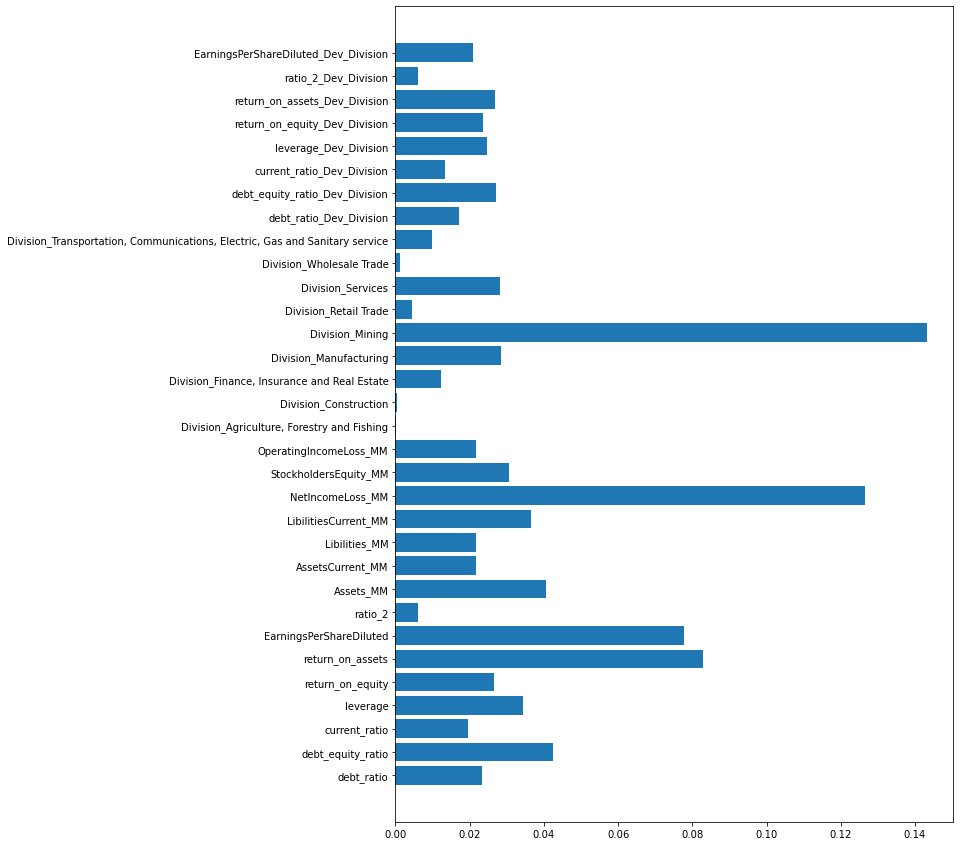

In [191]:
feature_names = feature_list

## last k-fold
plt.rcParams["figure.figsize"] = (10,15)
plt.barh(feature_names, randomforest.feature_importances_)

In [ ]:
#Precision-Recall curves summarize the trade-off between the true positive rate and 
#the positive predictive value for a predictive model using different probability thresholds.

#Precision-Recall curves appropriate for imbalanced classes


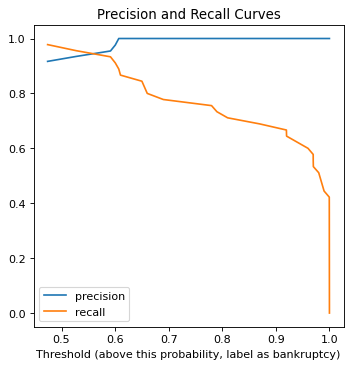

In [92]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val1, randomforest.predict_proba(X_val1)[:,1] )
plt.rcParams["figure.figsize"] = (5,5)
plt.figure(dpi=80)

plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:],label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as bankruptcy)');
plt.title('Precision and Recall Curves');

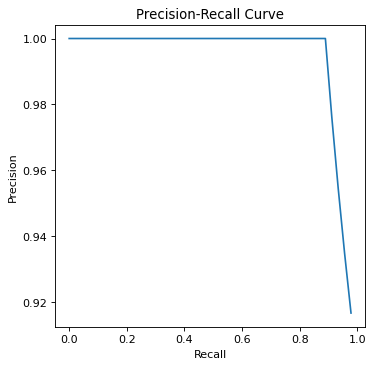

In [93]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

In [178]:
## confusion matrix
def make_confusion_matrix2(model):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    #y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    
    y_predict = model.predict(X_test)
    prob_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(prob_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['No', 'Yes'],
           yticklabels=['No', 'Yes']);
    plt.xlabel('Predicted Bankruptcy')
    
    plt.ylabel('Actual Bankruptcy')

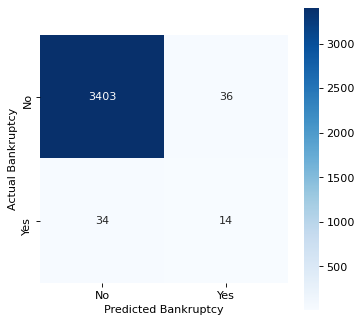

In [179]:

plt.rcParams["figure.figsize"] = (5,5)
make_confusion_matrix2(randomforest)

plt.savefig("cm_rfm.svg")